In [28]:
%matplotlib inline

import glob
from collections import Counter

import h5py
import pandas
import numpy as np

import pylab as plt

In [100]:
run = 656748
h5 = h5py.File('r%d/radials.h5'%run, 'r')
print( h5.keys())

[u'dark', u'pumped']


In [30]:
print(h5["pumped"].keys())

[u'Qrads', u'olaser_delay', u'olaser_volt', u'photon_energy', u'pulse_energy', u'radials', u'tag', u'xlaser_joule_bm_1', u'xlaser_joule_bm_2']


In [31]:
# nominal delay values
# Each unit corresponds to roughly 6.6 femtoseconds
# and time 0 is roughly olaser_delay=0
delay_vals = h5['pumped']['olaser_delay'].value # optical laser delay stage value

(14423,) (14423,)


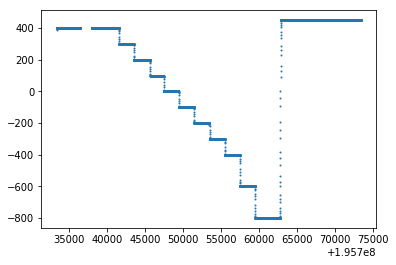

In [32]:
pumped_tag = h5['pumped/tag'].value
order = np.argsort( pumped_tag)
print pumped_tag.shape, delay_vals.shape
plt.plot( pumped_tag[order], delay_vals[order], '.', ms=2)
# watch how we changed the delay during this run
# negative stage olser_delay means

In [33]:
# Now those are the nominal delay values

# We wish to make the time delay more precise by using the 
# sub picosecond time-tool at SACLA

# This data is in the TMA results.CSV file(s) provided by SACLA
results = glob.glob("TMA/*/results.csv") # there are multiple files for different parts of the experiment

In [34]:
# this is the title row in each results.CSV
cols = 'tagNumber,time_of_getting_image[msec/tag],time_of_detection[msec/tag],time_of_writing_to_udb[msec/tag],deriv_edge,fit_edge,memory_used[MB/core]'.split(
    ',')
print(cols)

['tagNumber', 'time_of_getting_image[msec/tag]', 'time_of_detection[msec/tag]', 'time_of_writing_to_udb[msec/tag]', 'deriv_edge', 'fit_edge', 'memory_used[MB/core]']


In [35]:
# load the data from each results.CSV file and store in a large array
data = np.vstack(
        [np.loadtxt(r, skiprows=1, delimiter=',') for r in results ])


In [118]:
# convert the array data to a pandas dataframe
df = pandas.DataFrame(columns=cols, data=data) # this is the tma data for the entire experiment

In [119]:
# lets query the tma data for the particular run 

# first, we find the minimum and maximum tag number in our experimental data h5 file
tags = np.hstack( (h5['dark']['tag'].value, h5['pumped']['tag'].value))
tmin, tmax = tags.min(), tags.max()

# then we query the time-tool dataframe
df_run = df.query("tagNumber >= %d and tagNumber <= %d" % (tmin, tmax))
print ("%d shots in run %s"%(len( df_run), h5.filename) )

20000 shots in run r656748/radials.h5


In [120]:
# Now , we should merge this TMA data frame with the experimental data in the hdf5 file

pumped = h5['pumped']
dark = h5['dark']

# These are the relevant bits of the files, in particular the energy, radials and tag number
df_pumped_h5data = pandas.DataFrame({'radials': list(pumped['radials'].value),
                        'tagNumber': pumped['tag'].value, # note we keep same name tagNumber as the TMA data for merging
                        'olaser_delay': pumped['olaser_delay'].value,
                        'pulse_energy': pumped['pulse_energy'].value,
                        'photon_energy': pumped['photon_energy'].value,
                        'olaser_volt': pumped['olaser_volt'].value,
                        'xlaser_joule_bm_1': pumped['xlaser_joule_bm_1'].value})

# the dame for the dark data
df_dark_h5data = pandas.DataFrame({'radials': list(dark['radials'].value),
                        'tagNumber': dark['tag'].value, # note we keep same name tagNumber as the TMA data for merging
                        'olaser_delay': dark['olaser_delay'].value,
                        'pulse_energy': dark['pulse_energy'].value,
                        'photon_energy': dark['photon_energy'].value,
                        'olaser_volt': dark['olaser_volt'].value,
                        'xlaser_joule_bm_1': dark['xlaser_joule_bm_1'].value})

#NOTE: we made pumped[radials] a list, this is slightly abusing the pandas philosophy
# but it is quite convenient because we can keep all the parameters aligned 
# when we analyze the radials

# NOTE: if radials is left as a numpy array pandas will raise an exception

In [121]:
# We can join the pumped and dark dataframes into one

# To do so, we first create a boolean column called pumped
df_pumped_h5data['pumped'] = True
df_dark_h5data['pumped'] = False

# then we can concatenate
df_h5 = pandas.concat( (df_pumped_h5data, df_dark_h5data))

In [122]:
print (list(df_h5), len(df_h5))

(['olaser_delay', 'olaser_volt', 'photon_energy', 'pulse_energy', 'radials', 'tagNumber', 'xlaser_joule_bm_1', 'pumped'], 19230)


In [132]:
# Now we can merge the hdf5 dataframe with the SACLA time tool dataframe
df_main = pandas.merge(df_run, df_h5, on='tagNumber') # NOTE: pandas does an inner merge by default
print( list(df_main), len( df_main))

(['tagNumber', 'time_of_getting_image[msec/tag]', 'time_of_detection[msec/tag]', 'time_of_writing_to_udb[msec/tag]', 'deriv_edge', 'fit_edge', 'memory_used[MB/core]', 'olaser_delay', 'olaser_volt', 'photon_energy', 'pulse_energy', 'radials', 'xlaser_joule_bm_1', 'pumped'], 19230)


In [133]:
# During the experiment, as the optical laser delay stage was translated, 
# the olaser_delay values being read out changed continuously.

# This was because the time to jump from one delay stage value to another
# was much longer than the time between shots. 

# Therefore, we need to isolate the fixed values of olaser_delay in order 
# to query the nominal delay values.

# Usually, if a value is read out 10+ times in a row,  it's considered a fixed value
all_olaser_vals = Counter( df_main.olaser_delay.values)
print (all_olaser_vals.items() )  # (olaser_value, frequency) pairs


[(0, 971), (1, 1), (3, 1), (-508, 1), (5, 1), (-502, 1), (11, 1), (-424, 1), (19, 1), (-488, 1), (30, 1), (-681, 1), (43, 1), (-800, 1631), (46, 1), (-464, 1), (57, 1), (-453, 1), (70, 1), (-439, 1), (80, 1), (-427, 1), (88, 2), (94, 1), (-417, 1), (98, 1), (99, 1), (100, 859), (101, 1), (-410, 1), (104, 1), (-404, 1), (110, 1), (-401, 1), (-400, 974), (-201, 1), (-398, 1), (118, 1), (-388, 1), (127, 2), (-383, 1), (-379, 1), (140, 1), (-368, 1), (-630, 1), (410, 1), (154, 1), (-354, 1), (-656, 1), (163, 1), (167, 1), (-340, 1), (-339, 1), (178, 1), (-328, 1), (187, 1), (193, 1), (-318, 1), (197, 1), (198, 1), (199, 1), (200, 1074), (-310, 1), (203, 1), (-305, 1), (208, 1), (-302, 1), (-300, 991), (-298, 1), (215, 1), (-295, 1), (-292, 1), (224, 1), (-799, 1), (-798, 1), (-797, 1), (-794, 1), (-793, 1), (-280, 1), (236, 1), (-787, 2), (-269, 1), (-778, 2), (250, 1), (-256, 1), (-767, 2), (-469, 1), (260, 1), (263, 1), (-244, 1), (-242, 1), (-211, 1), (275, 1), (-229, 1), (284, 1), (-73

In [142]:
good_delays = [k for k, v in all_olaser_vals.items() if v > 10]
print ( good_delays) # store these numbers for later use in analysis queries

[0, -800, 100, -400, 200, -300, 300, -200, 400, -100, -600, 450]


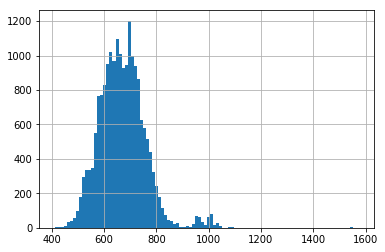

In [135]:
# Above are the nominal delay values that were set during this run
# (remember, the units correspond to roughly 6.6 picoseconds of delay)

# We can calculate the time-delay per shot using the fit_edge from the time-tool data

# Lets look at the time tool fit_edge position across the run
df_main.fit_edge.hist(bins=100)

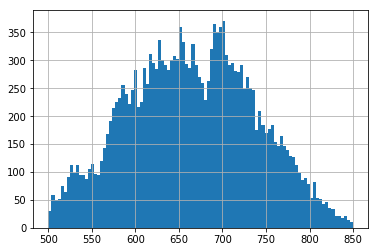

In [136]:
# Looks like some outliers near edge positions 1000, so lets give a modest crop to the fit_edge
df_main = df_main.query('fit_edge > %d and fit_edge < %d' % (500, 850))
df_main.fit_edge.hist( bins=100)

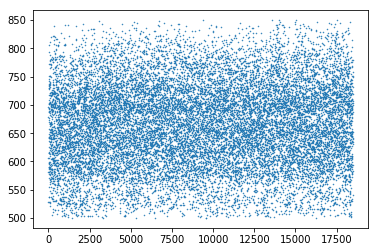

In [137]:
# lets watch how this fit_edge is changing in time by sorting according to tagNumber
plt.plot( df_main.fit_edge[np.argsort(df_main.tagNumber)], '.', ms=1)

In [138]:
# It looks like the fit_edge is pretty uniform across this sun, 

# Therefore, we can assume the average fit_edge is the nominal time delay.

# The correction to the time delay is ~3 femtosecond per fit_edge
# and arrival timing increases with fit_edge
df_main['time_adjust'] = (df_main.fit_edge - df_main.fit_edge.mean()) * 0.003

In [139]:
# now , we commpute the per-shot time delay: (olaser_delay unit is roughly 6.6 femtoseconds)
df_main['delay_time'] = df_main.olaser_delay * 0.0066 + df_main.time_adjust

In [140]:
# lets save this dataframe
df_main.to_pickle("run%d_main.pkl"%run)

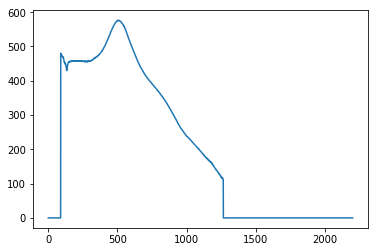

In [141]:
# the dataframe is quite useful
# e.g. to plot the average pumped radial profile
plt.plot( df_main.query("pumped==True").radials.mean(0) )
# The next notebook explains how to do detailed analysis